In [1]:
import tensorflow as tf

In [14]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow import keras
import time
import cv2
from IPython import display

In [3]:
#if you are allegic with flashing screen pls. don't watch this cell while running
PATH = './animefacedataset'
file_list =[]
img_list = []
#load all data
def get_data(path=PATH):
    sub_dir = os.listdir(path)
    for i in sub_dir:
        curr = path+'/'+i
        if os.path.isdir(curr):
            get_data(curr)
        else:
            file_list.append(curr)
get_data()
#check for invalid data
j = 0
k = 0
start_load = time.time()
for i in file_list:
    tmp_time = time.time()
    j+=1
    try:
        tmp_img = cv2.imread(i)
        tmp_img = cv2.resize(tmp_img,(32,32))
        img_list.append(tmp_img)
        if(j%2000 == 0):
            print("load {} files, {:4.2g} sec for loading process".format(j,int(time.time()-start_load)))
    except:
        if k == 0:
            print("list of uncompatible file(s)........")
        print(i)
        k+=1
    display.clear_output(wait=True)
d_in = np.array(img_list)
d_in = d_in.astype('float32')
d_in = (d_in-127.5)/127.5
print(len(d_in))

63565


In [4]:
BUFFER_SIZE = len(d_in)
BATCH_SIZE = 64

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(d_in).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
num_data = 0
for i in train_dataset:
    num_data += 1
print(num_data)

994


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16,16, 128)))
    assert model.output_shape == (None, 16, 16, 128) # Note: None is the batch size

    model.add(layers.Conv2D(256, 5, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256,4,strides=2,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256, 5, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, 7, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

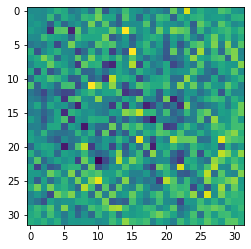

In [7]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
#check is it work
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[9.538594e-05]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [16]:
#incase of any emergency
checkpoint_dir = './cache'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    train_data = 0
    for image_batch in dataset:
      tmp_time = time.time()
      train_step(image_batch)
      train_data +=1
      if(time.time()-tmp_time > 2):
            print('Percentage of progress in {} epochs is {}%'.format(epoch+1,(train_data/num_data*100)))
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                            seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

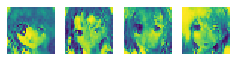

In [21]:
train(train_dataset, EPOCHS)

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))